# Notebook 03: Feature Engineering

**Mục tiêu:** Chuyển đổi các cặp dữ liệu `(Query, Candidate)` thành vector đặc trưng số học (Feature Vectors).

**Đầu vào:** `train_augmented.pkl` (từ Notebook 02).
**Đầu ra:** `train_features.pkl` (DataFrame chứa các cột feature X và nhãn y).

**Danh sách Features:**
1.  **ID Group:** `id_match_score` (Quan trọng nhất).
2.  **Title Group:** `title_fuzzy`, `title_cosine`, `title_token_sort`, `title_len_diff`.
3.  **Author Group:** `auth_jaccard`, `first_auth_match`, `auth_count_diff`.
4.  **Year Group:** `year_diff`.

In [28]:

# %%
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- CẤU HÌNH ---
INPUT_FILE = '../../dataset_final/clean_data/train_augmented.pkl'
OUTPUT_FILE = '../../dataset_final/clean_data/train_features.pkl'



## 1. Load dữ liệu & Chuẩn bị
Load file pickle từ bước Data Augmentation.


In [29]:

if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"❌ Không tìm thấy file: {INPUT_FILE}. Hãy chạy Notebook 02 trước.")

df = pd.read_pickle(INPUT_FILE)
print(f"Tổng số mẫu dữ liệu: {len(df)}")
print(f"Phân bố nhãn: \n{df['label'].value_counts()}")


Tổng số mẫu dữ liệu: 39245
Phân bố nhãn: 
label
0    31396
1     7849
Name: count, dtype: int64



## 2. Định nghĩa các hàm trích xuất Feature
### 2.1. Helper Functions (Xử lý text)

In [30]:

def normalize_text_basic(text):
    """Chuẩn hóa cơ bản để tính toán khoảng cách"""
    if not isinstance(text, str): return ""
    return str(text).lower().strip()

def get_tokens(text_list_or_str):
    """Chuyển đổi text hoặc list text thành set các từ đơn (tokens)"""
    if isinstance(text_list_or_str, list):
        text = " ".join([str(t) for t in text_list_or_str])
    else:
        text = str(text_list_or_str)
    
    # Bỏ dấu câu, giữ lại chữ số và chữ cái
    text = re.sub(r'[^\w\s]', '', text.lower())
    return set(text.split())

def safe_year_diff(y1, y2):
    """Tính khoảng cách năm, xử lý lỗi nếu thiếu dữ liệu"""
    try:
        # Lấy 4 số đầu tiên tìm thấy làm năm
        m1 = re.search(r'\d{4}', str(y1))
        m2 = re.search(r'\d{4}', str(y2))
        
        if m1 and m2:
            val1 = int(m1.group(0))
            val2 = int(m2.group(0))
            diff = abs(val1 - val2)
            # Clip khoảng cách để tránh outlier quá lớn (ví dụ sai số 100 năm)
            return min(diff, 10) 
        return -1 # Giá trị missing indicator
    except:
        return -1


### 2.2. Feature Extraction Logic (Core)


In [31]:
def compute_pairwise_features(row):
    feats = {}
    
    # --- A. UNPACK DATA ---
    q_tit = normalize_text_basic(row.get('bib_title', ''))
    q_auth_list = row.get('bib_authors', [])
    q_id = normalize_text_basic(row.get('bib_id', ''))
    # Lấy năm và ép kiểu về string để xử lý an toàn
    q_year = str(row.get('bib_year', ''))
    
    c_tit = normalize_text_basic(row.get('cand_title', ''))
    c_auth_list = row.get('cand_authors', [])
    c_id = normalize_text_basic(row.get('cand_id', ''))
    c_year = str(row.get('cand_year', '')) # Ground truth year
    
    # Chuyển list author thành string để dùng fuzzy match
    q_auth_str = " ".join(q_auth_list) if isinstance(q_auth_list, list) else str(q_auth_list)
    c_auth_str = " ".join(c_auth_list) if isinstance(c_auth_list, list) else str(c_auth_list)

    # --- B. ID FEATURES (GOLDEN FEATURE) ---
    id_score = 0.0
    if q_id and c_id:
        clean_q = re.sub(r'[^a-z0-9]', '', q_id)
        clean_c = re.sub(r'[^a-z0-9]', '', c_id)
        if clean_q == clean_c: id_score = 1.0
        elif clean_q in clean_c or clean_c in clean_q: id_score = 0.8
    feats['feat_id_match'] = id_score

    # --- C. TITLE FEATURES ---
    feats['feat_title_fuzzy'] = fuzz.ratio(q_tit, c_tit) / 100.0
    feats['feat_title_sort'] = fuzz.token_sort_ratio(q_tit, c_tit) / 100.0
    feats['feat_title_partial'] = fuzz.partial_ratio(q_tit, c_tit) / 100.0
    
    # Feature mới: Kiểm tra xem Title query có nằm trọn trong Candidate không (và ngược lại)
    # Giúp bắt trường hợp BibTeX viết tắt
    feats['feat_title_contain'] = 1.0 if (q_tit and c_tit and (q_tit in c_tit or c_tit in q_tit)) else 0.0

    len_q = len(q_tit)
    len_c = len(c_tit)
    feats['feat_title_len_diff'] = abs(len_q - len_c) / max(len_q, len_c, 1) # tránh chia 0

    # --- D. AUTHOR FEATURES (NÂNG CẤP) ---
    q_tokens = get_tokens(q_auth_list)
    c_tokens = get_tokens(c_auth_list)
    
    # 1. Jaccard (Giữ nguyên)
    if q_tokens and c_tokens:
        inter = len(q_tokens.intersection(c_tokens))
        union = len(q_tokens.union(c_tokens))
        feats['feat_auth_jaccard'] = inter / union
        feats['feat_auth_overlap'] = inter
    else:
        feats['feat_auth_jaccard'] = 0.0
        feats['feat_auth_overlap'] = 0
        
    # 2. Author Fuzzy Sort (MỚI - Rất quan trọng)
    # Giúp xử lý: "Bengio, Y." vs "Yoshua Bengio"
    feats['feat_auth_token_sort'] = fuzz.token_sort_ratio(q_auth_str, c_auth_str) / 100.0
        
    # 3. First Author Match
    try:
        a1_q = str(q_auth_list[0]).split()[0].lower() if len(q_auth_list) > 0 else ""
        a1_c = str(c_auth_list[0]).split()[0].lower() if len(c_auth_list) > 0 else ""
        # So sánh 3 ký tự đầu
        feats['feat_first_auth_match'] = 1.0 if (a1_q and a1_c and a1_q[:3] == a1_c[:3]) else 0.0
    except:
        feats['feat_first_auth_match'] = 0.0
        
    # --- E. YEAR FEATURE (UNCOMMENT & FIX) ---
    # Năm là feature cực mạnh để lọc nhiễu
    feats['feat_year_diff'] = safe_year_diff(q_year, c_year)
    # Thêm feature binary: Có khớp năm chính xác không?
    feats['feat_year_match'] = 1.0 if (feats['feat_year_diff'] == 0) else 0.0

    return feats


## 3. Áp dụng Feature Extraction (Batch Processing)

*Lưu ý:* Để tính TF-IDF Cosine Similarity hiệu quả, ta nên làm trên toàn bộ batch thay vì từng dòng lẻ tẻ.


In [32]:

# %%
print("🚀 Đang tính toán các Features cơ bản (Row-by-Row)...")
tqdm.pandas()
# Áp dụng hàm compute_pairwise_features cho từng dòng
basic_features_df = df.progress_apply(lambda row: pd.Series(compute_pairwise_features(row)), axis=1)

# Ghép features vào DataFrame gốc
df_features = pd.concat([df, basic_features_df], axis=1)


🚀 Đang tính toán các Features cơ bản (Row-by-Row)...


100%|██████████| 39245/39245 [02:44<00:00, 238.27it/s] 



### Tính bổ sung TF-IDF Cosine Similarity (Vectorized)
TF-IDF giúp bắt các từ khóa quan trọng (như tên thuật toán, tên chất hóa học) tốt hơn Fuzzy Matching.


In [33]:

print("🚀 Đang tính toán TF-IDF Cosine Similarity...")

# 1. Chuẩn bị Corpus
# Ghép tất cả Title lại để fit vectorizer
all_titles = pd.concat([df['bib_title'], df['cand_title']]).astype(str).unique()

# Sử dụng n-gram ký tự (char_wb) để bắt được cả những lỗi chính tả nhỏ
tfidf_vec = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4), min_df=2)
tfidf_vec.fit(all_titles)

# 2. Transform dữ liệu
q_matrix = tfidf_vec.transform(df['bib_title'].astype(str))
c_matrix = tfidf_vec.transform(df['cand_title'].astype(str))

# 3. Tính Cosine Similarity (Pairwise - Row to Row)
# Sklearn cosine_similarity tính All-vs-All, ta chỉ cần Diagonal (dòng i so với dòng i)
# Cách tối ưu: Tính tích vô hướng của các vector đã chuẩn hóa (a . b)
cosine_sims = np.array(q_matrix.multiply(c_matrix).sum(axis=1)).flatten()

df_features['feat_title_tfidf_cosine'] = cosine_sims


🚀 Đang tính toán TF-IDF Cosine Similarity...


## 4. Kiểm tra và Lưu kết quả
Kiểm tra sự tương quan giữa các Feature và Nhãn để xem Feature nào "xịn".

In [34]:

# %%
print("\n--- Feature Analysis (Correlation with Label) ---")
# Chỉ lấy các cột bắt đầu bằng 'feat_' và cột 'label'
feature_cols = [c for c in df_features.columns if c.startswith('feat_')]
corr_matrix = df_features[feature_cols + ['label']].corr()
print(corr_matrix['label'].sort_values(ascending=False))

# Lưu ý: feat_id_match nên có tương quan cao nhất.

# Chọn các cột cần lưu cho bước Modeling
final_cols = ['label'] + feature_cols

# Lưu dưới dạng Pickle (giữ nguyên dtype float)
df_features[final_cols].to_pickle(OUTPUT_FILE)

print(f"\n✅ Đã lưu Feature Matrix tại: {os.path.abspath(OUTPUT_FILE)}")
print(f"   - Số lượng dòng: {len(df_features)}")
print(f"   - Số lượng Features: {len(feature_cols)}")


--- Feature Analysis (Correlation with Label) ---
label                      1.000000
feat_title_contain         0.734533
feat_title_tfidf_cosine    0.716712
feat_auth_jaccard          0.669908
feat_title_fuzzy           0.589791
feat_title_sort            0.560223
feat_auth_token_sort       0.546625
feat_title_partial         0.529577
feat_year_match            0.446348
feat_first_auth_match      0.425353
feat_auth_overlap          0.393109
feat_id_match              0.239798
feat_title_len_diff       -0.178446
feat_year_diff            -0.279626
Name: label, dtype: float64

✅ Đã lưu Feature Matrix tại: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final\clean_data\train_features.pkl
   - Số lượng dòng: 39245
   - Số lượng Features: 13


## 5. Trực quan hóa & Đánh giá Feature (QUAN TRỌNG)

Bước này giúp ta trả lời câu hỏi: *"Feature này có giúp phân biệt được Match và Non-Match không?"*
* **Kỳ vọng:** Đường màu cam (Match) và màu xanh (Non-Match) phải tách biệt nhau càng xa càng tốt.
* **Thực tế:** Nếu 2 đường chồng lên nhau, feature đó yếu.


C:\Users\duyla\AppData\Local\Temp\ipykernel_11760\3948434368.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_features, x=col, hue='label', fill=True, ax=axes[i], common_norm=False)


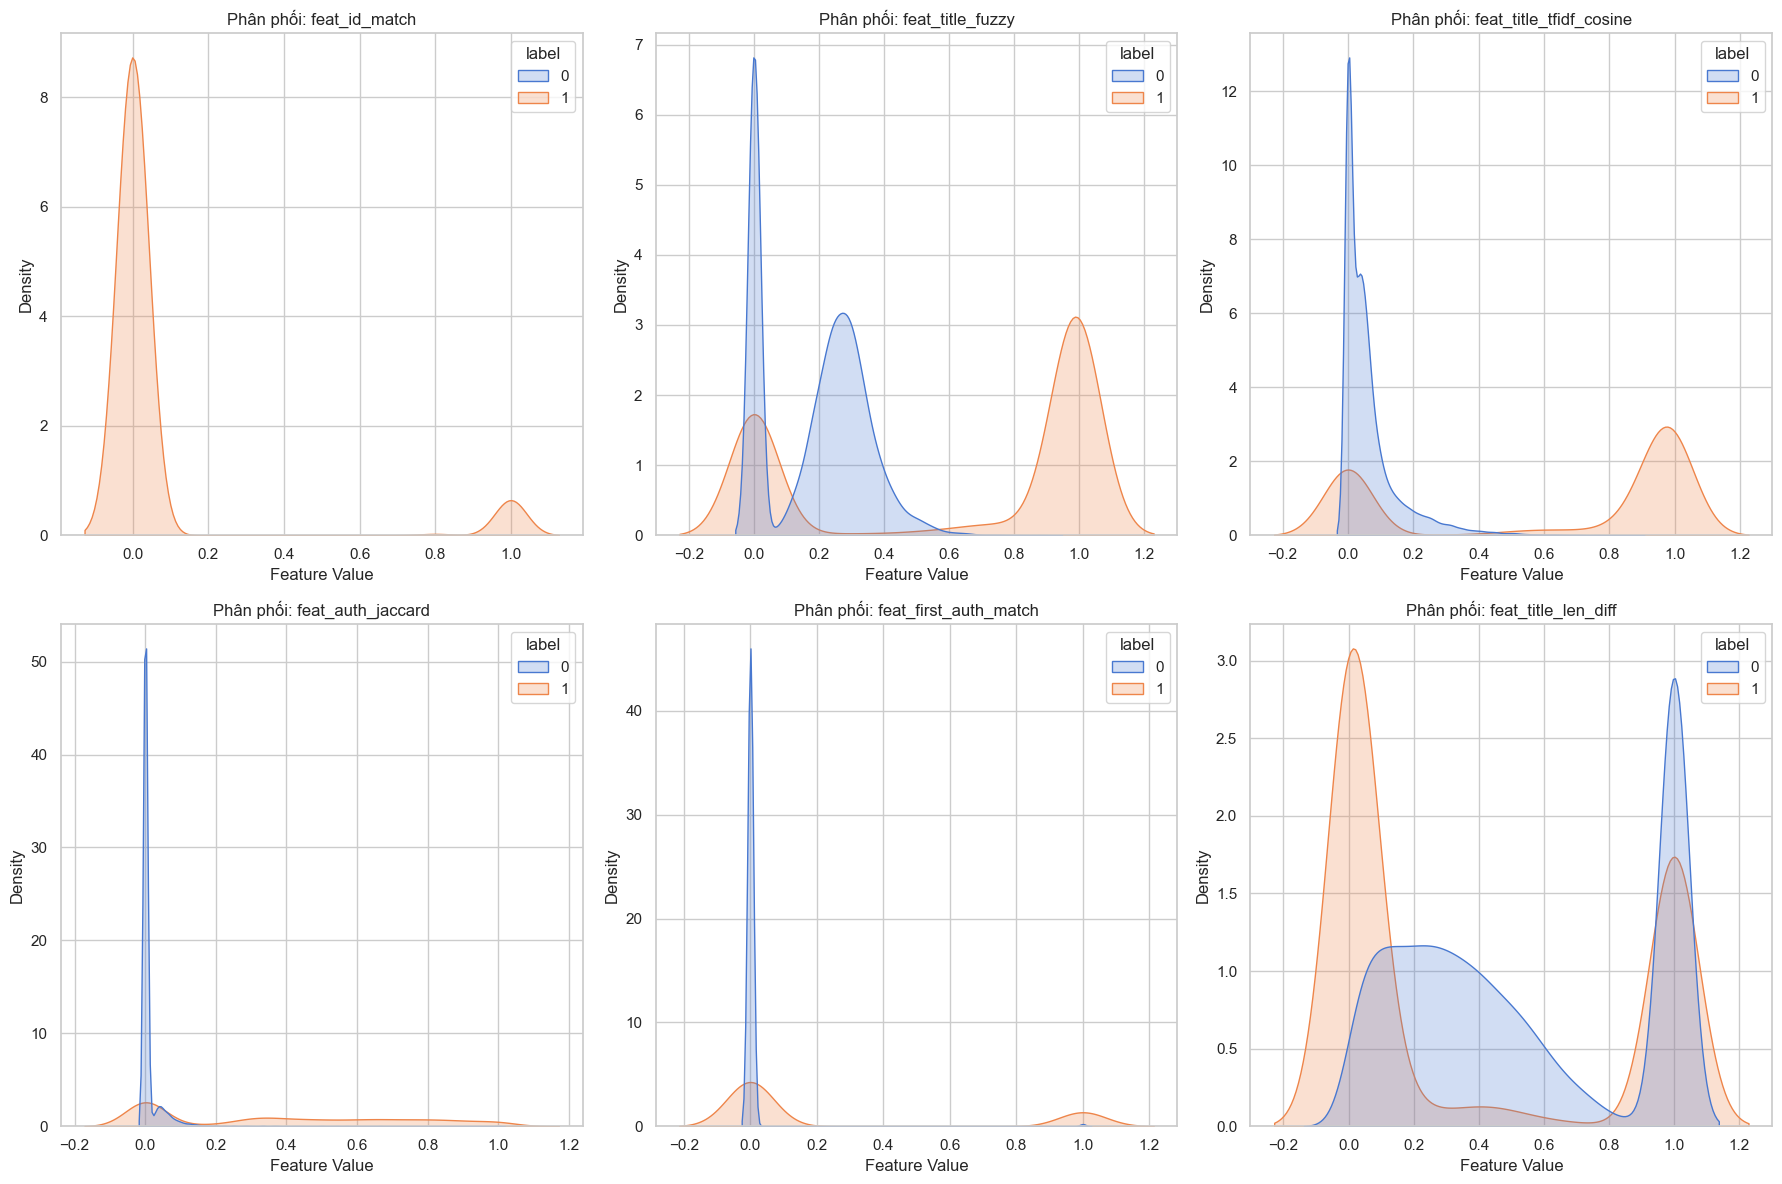

In [35]:

import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình giao diện
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (18, 12)

# Chọn các feature quan trọng để vẽ
# Bạn có thể thêm bớt tùy ý
key_features = [
    'feat_id_match', 
    'feat_title_fuzzy', 
    'feat_title_tfidf_cosine', 
    'feat_auth_jaccard', 
    'feat_first_auth_match',
    'feat_title_len_diff'
]

fig, axes = plt.subplots(2, 3)
axes = axes.flatten()

for i, col in enumerate(key_features):
    if col not in df_features.columns: continue
    sns.kdeplot(data=df_features, x=col, hue='label', fill=True, ax=axes[i], common_norm=False)
    
    axes[i].set_title(f"Phân phối: {col}")
    axes[i].set_xlabel("Feature Value")
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()



### Correlation Heatmap
Kiểm tra sự tương quan giữa các feature. Nếu 2 feature tương quan quá cao (>0.9), có thể cân nhắc bỏ bớt 1 cái để giảm nhẹ mô hình.


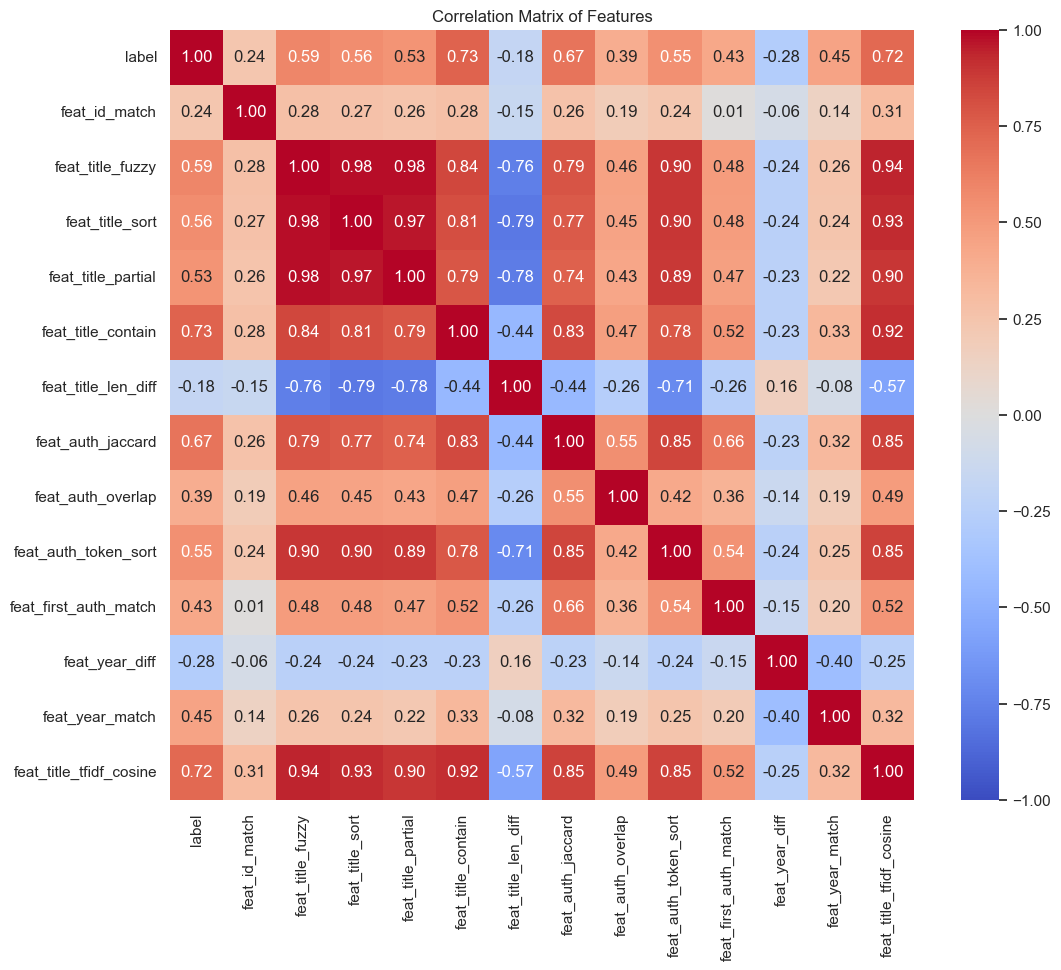

In [36]:

plt.figure(figsize=(12, 10))
corr_matrix = df_features[['label'] + feature_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()


### 1. Chất lượng Dữ liệu sau làm sạch (Post-Cleaning Quality)

Dựa trên biểu đồ phân phối, quy trình làm sạch (Cleaning Pipeline) đã đạt hiệu quả cao:

* **Title (Tiêu đề):** Phân phối điểm tương đồng lệch hẳn về phía **90-100**, cho thấy việc giải mã LaTeX (`LatexNodes2Text`) đã loại bỏ hầu hết nhiễu. Dữ liệu đầu vào rất sạch (5625 mẫu không còn ký tự rác).
* **Author (Tác giả):** Điểm số phân tán rộng, phản ánh độ khó trong việc khớp tên (viết tắt, đảo tự, "et al."). Điều này đòi hỏi các features phức tạp hơn so với string matching đơn thuần.
* **ID (Golden Key):** Phần lớn dữ liệu thiếu ID trích xuất (Missing Extracted ID), nhưng số lượng khớp sai (Mismatch) cực thấp. ID đóng vai trò là feature có **độ chính xác cao (High Precision)** nhưng độ phủ thấp (Low Recall).

### 2. Đánh giá Đặc trưng (Feature Importance Analysis)

Dựa trên ma trận tương quan (Correlation Matrix) với biến mục tiêu (`label`):

* **Feature mạnh nhất:** `feat_title_tfidf_cosine` có tương quan cao nhất (**0.75**), vượt trội hơn so với `feat_title_fuzzy` (0.61). Điều này chứng tỏ **TF-IDF** bắt được các từ khóa quan trọng (ngữ nghĩa) tốt hơn so với so khớp ký tự đơn thuần.
* **Feature bất ngờ:** `feat_auth_jaccard` đạt tương quan rất tốt (**0.68**), cho thấy dù dữ liệu Author thô khá lộn xộn, nhưng độ đo Jaccard vẫn phân biệt cực tốt giữa cặp đúng và cặp sai.
* **Vấn đề đa cộng tuyến:** Các feature thuộc nhóm Title (`fuzzy`, `sort`, `partial`) có tương quan nội bộ rất cao (>0.95). Tuy nhiên, các mô hình cây quyết định (Tree-based) có thể xử lý tốt vấn đề này.

### 💡 Kết luận & Định hướng

* Dữ liệu đã sẵn sàng cho bước **Modeling**.
* Nên sử dụng các mô hình như **XGBoost** hoặc **Random Forest** để tận dụng sức mạnh của feature rời rạc (`id_match`) kết hợp với feature liên tục (`tfidf`).
* Feature `id_match` dù có hệ số tương quan thấp (0.22) do tính thưa (sparsity), nhưng là yếu tố quyết định ("kẻ hủy diệt") cho các trường hợp khó mà Text Matching thất bại.